# Stock Price Prediction Using Technical Indicators and Deep Learning

Stock price prediction has proven to be a challenging and volatile task. The presence of noise, market sentiment, and external factors makes it almost impossible to predict the movement of a stock. However, advancements in machine learning have shown promise in predicting stock data by leveraging historical data. In this project, I explore the possibility of predicting Tesla's (TSLA) stock price using a combination of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks, supported with technical analysis indicators.

The goal of this project is to use historical price data and technical indicators such as momentum indicators, moving averages, and volatility measures to predict TSLA's future stock prices. LSTM networks are best for this task because of its ability to capture long-term relationships in time series data, while CNN layers will help the model detect short-term patterns and volatility. By combining these networks with technical indicators, we aim to build a model to improve prediction accuracy and robustness during periods of high market volatility.

## Data Collection

Historical stock price data for Tesla is retrieved using the `yfinance` library, which fetches stock data directly from the Yahoo Finance API. The data covers the period from January 1, 2015, to the present, with daily price records that include:

- `Open` - The start of day price
- `High` - The highest price reached throughout the day.
- `Low` - The minimum price reached throughout the day.
- `Close` - The end of day price
- `Volume` - The number of shares that were traded on that day

In [97]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

from ta.trend import EMAIndicator, MACD
from ta.momentum import RSIIndicator, ROCIndicator, StochasticOscillator
from ta.volatility import AverageTrueRange

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, r2_score

from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv1D, Bidirectional
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

In [98]:
# import data
tsla = yf.download('TSLA', start='2015-01-01')
tsla.columns = tsla.columns.get_level_values(0)
tsla.columns.name = None
obs = np.arange(1, len(tsla) + 1, 1)
tsla.head()

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


## Feature Engineering

To give the model more context, several financial indicators are added to aid the model in understanding the different aspects of the stock's behaviour:

**1. Exponential Moving Averages (EMA)**

- Short-term (EMA20) and long-term (EMA100) moving averages provide the model with understanding of both quick price changes and long-term trends.

**2. Moving Average Convergence Divergence (MACD)**

- The MACD finds momentum shifts by comparing short-term and long-term EMAs, providing important information about possible reversals or trend persistence.

**3. Relative Strength Index (RSI)**

- The RSI tells us wether a stock is overbought or oversold, which can directly cause price reversals.

**4. Rate of Change (ROC)**

- The ROC tells us how fast the stock price changes, provinding information on the strength of a price movement.

**5. Average True Range (ATR)**

- The ATR is a measure of volatility, it will help the model learn in intervals of higher market risk.

**6. Stochastic Oscillator (%K and %D)**

- This oscillator compares the current closing price to the price range over a period, helping us discover overbought or oversold conditions.

These indicators are calculated using the `ta` library and capture hidden information within the price data itself. They tell you why the price is moving the way it is and how strong the movement is. Once we have added these indicators to the dataframe, any rows containing `NaN` values are dropped.

In [ ]:
# indicators
tsla['OHLC_avg'] = tsla[['Open', 'High', 'Low', 'Close']].mean(axis=1)
tsla['HLC_avg'] = tsla[['High', 'Low', 'Close']].mean(axis=1)
stoch = StochasticOscillator(tsla['High'], tsla['Low'], tsla['Close'], 
                             window=14, smooth_window=3)
tsla['Stoch_%K'] = stoch.stoch()
tsla['Stoch_%D'] = stoch.stoch_signal()

# trend indicators
tsla['EMA20'] = EMAIndicator(tsla['Close'], window=20).ema_indicator()
tsla['EMA100'] = EMAIndicator(tsla['Close'], window=100).ema_indicator()
macd = MACD(close=tsla['Close'])
tsla['MACD'] = macd.macd()
tsla['MACD_diff'] = macd.macd_diff()

# momentum indicators
tsla['RSI'] = RSIIndicator(tsla['Close'], window=14).rsi()
tsla['ROC'] = ROCIndicator(close=tsla['Close'], window=5).roc()
tsla['Pct_Change'] = tsla['Close'].pct_change()

# volatility indicators
tsla['ATR'] = AverageTrueRange(tsla['High'], tsla['Low'], tsla['Close'], 
                               window=14).average_true_range()

tsla.dropna(inplace=True)
tsla.reset_index(drop=True, inplace=True)
obs = np.arange(1, len(tsla) + 1, 1)

## Data Processing

A sliding window approach is used to structure the data. For a step size of 30 days, the model takes the indicators and stock prices from the last 30 days to predict the closing price on the 31st day. The model will then proceed to learn from the historical price patterns and technical signals. 

Before feeding the data into the model, a `MinMaxScaler` is applied to scale the data between 0 and 1, a crucial step since the indicators and price values are on different scales. Scaling ensures all features contribute equally to learning.

The data is then split into training and test sets, with 75% of the data used for training and 25% for testing, while preserving order to preserve dependencies. The final dataset consists of 30-day windows of features each with corresponding target prices.

In [ ]:
# scale features
features = tsla[['OHLC_avg', 'HLC_avg', 'Close', 'EMA20', 'EMA100', 
                 'RSI', 'Volume', 'MACD', 'MACD_diff', 'ROC', 
                 'Pct_Change', 'ATR', 'Stoch_%K', 'Stoch_%D']]
target = tsla[['Close']]

feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(features)

target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(target)

In [101]:
def create_sequences(data_X, data_y, step_size):
    X, y = [], []
    for i in range(len(data_X) - step_size):
        X.append(data_X[i:i + step_size])
        y.append(data_y[i + step_size])
    return np.array(X), np.array(y)

In [102]:
# create sequences
step_size = 30
X, y = create_sequences(X_scaled, y_scaled, step_size)
X = X.reshape(X.shape[0], X.shape[1], X.shape[2])

In [103]:
# train-test split
split = int(len(X)*0.75)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

## Model Architecture & Training

The model is built using a combination of Convolutional Neural Networks (CNNs) and Long Short-Term Memory (LSTM) networks to predict TSLA's stock price.

**Conv1D Layer:**

- Applies convolutional filters to extract important features from the time series data. Helps the model capture short-term patterns or sudden price changes.

**LSTM Layers:**

- **First LSTM Layer:** Learns patterns in the sequence data, captures long-term dependencies
- **Second LSTM Layer:** Furter refines predictions by continuing to learn relationships, helping the model generalize better.

**Dropout Layers:**
- Incorporated in between LSTM layers to prevent overfitting by randomly disabling some neurons during training. Forces the model to learn more robust features

**Dense Layer:**
- Outputs a single value, representing the predicted stock price for the next day

**L2 Regularization:**
- Applied to the Conv1D and Dense layers to prevent overfitting, and penalize large weights.

The model is then compiled with Adam as the optimizer and Huber loss (handles outliers well). Early stopping halts training early when no improvement in validation loss is seen, restoring optimal weights and thus avoiding overfitting. 

The model is trained for 20 epochs with a batch size of 32.

In [104]:
# build LSTM model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', 
                 input_shape=(step_size,14), kernel_regularizer=l2(1e-4)))
model.add(LSTM(64, return_sequences=True, kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.3))
model.add(LSTM(32, kernel_regularizer=l2(1e-4)))
model.add(Dropout(0.3))
model.add(Dense(1, activation='linear', kernel_regularizer=l2(1e-4)))

c:\Users\Developer\OneDrive\Desktop\Algorithmic Trading\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [105]:
# early stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

In [106]:
# model compiling and training
model.compile(
    loss='huber',
    optimizer='adam'
)

history = model.fit(
    X_train, y_train,
    validation_split=0.25,
    epochs=20,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0247 - val_loss: 0.0197
Epoch 2/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0129 - val_loss: 0.0108
Epoch 3/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0087 - val_loss: 0.0096
Epoch 4/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0064 - val_loss: 0.0076
Epoch 5/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0055
Epoch 6/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0044 - val_loss: 0.0056
Epoch 7/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0038 - val_loss: 0.0050
Epoch 8/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0034 - val_loss: 0.0043
Epoch 9/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0031 - val_loss: 0.0038
Epoch 10/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 11/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0026 - val_loss: 0.0043
Epoch 12/20
44/44 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0

## Evaluation & Metrics

To evaluate the model's performance, multiple metrics were used to assess how well the model predicted TSLA's stock prices.

### Training vs Validation Loss Over Epochs

The plot below shows how the training loss and validation loss changes as the model is trained over 20 epochs. We see training loss decreases smoothly, wheras the validation loss fluctuates throughout the epochs.

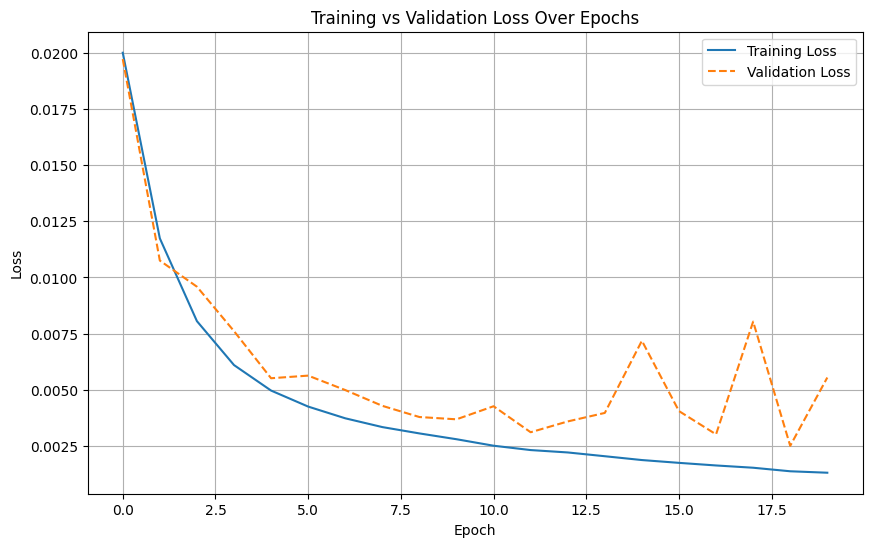

In [107]:
# training & validation loss plot
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', linestyle='--')
plt.title('Training vs Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

The stable decline in training loss indicates that the model is learning successfully from the data, but the oscillating validation loss might be a sign that the model is overfitting. The validation loss oscillates upward at some points, indicating that the model begins to memorize the training data instead of learning patterns. This might happen due to a lack of sufficient regularization or too complicated of a model structure.

### Root Mean Squared Error (RMSE)

RMSE for the training and testing sets are computed below. This metric is very sensitive to large errors, indicating that a model with high RMSE has large deviations from actual values.

In [108]:
# make predictions
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

# de-normalize predictions
trainPredict = target_scaler.inverse_transform(trainPredict)
y_train = target_scaler.inverse_transform(y_train.reshape(-1,1))
testPredict = target_scaler.inverse_transform(testPredict)
y_test = target_scaler.inverse_transform(y_test.reshape(-1,1))

58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [109]:
# training RMSE
train_score = np.sqrt(mean_squared_error(y_train, trainPredict[:,0]))
print(f'Train RMSE: {train_score}')

Train RMSE: 12.870558349442174


In [110]:
# testing RMSE
test_score = np.sqrt(mean_squared_error(y_test, testPredict[:,0]))
print(f'Test RMSE: {test_score}')

Test RMSE: 24.89188379189942


- **Training RMSE: 12.87**
- **Test RMSE: 24.89**

Training RMSE is relatively low, meaning the model fits the training data well. On the other hand, Test RMSE is higher, showing that the model struggles to generalize unseen data, especially when predicting a very volatile stock like TSLA. The gap between training and test RMSE suggests overfitting, consistent with what we discovered in the previous plot.

### Test Predictions vs Actual Prices

The plot below compares the predicted stock prices to the actual closing prices for the test set. The blue line is the actual stock prices while the orange line is the predicted prices.



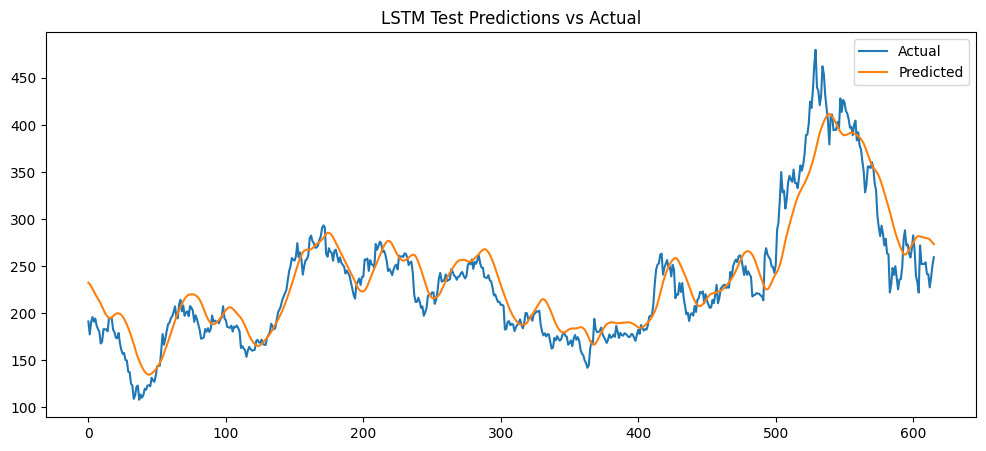

In [111]:
# visualize actual vs predicted
plt.figure(figsize=(12,5))
plt.plot(y_test, label='Actual')
plt.plot(testPredict, label='Predicted')
plt.title('LSTM Test Predictions vs Actual')
plt.legend()
plt.show()

We see that while the model does an excellent job capturing general trends, it struggles to predict sharp changes in price accurately, especially during volatile periods. This implies the model is better for capturing broader trends but may need improvements to predict sudden movements or extreme volatility more effectively.

### Training & Test Sets vs Actual Closing Price

The graph below compares the predicted closing prices for both the training set (red) and the test set (blue) to the actual closing prices (green).

In [ ]:
# structures for plotting
train_set_plot = np.full_like(target.values.ravel(), fill_value=np.nan, 
                              dtype=np.float64)
test_set_plot = np.full_like(target.values.ravel(), fill_value=np.nan, 
                             dtype=np.float64)

L = step_size+len(trainPredict)
R = step_size+len(trainPredict)+len(testPredict)
train_set_plot[step_size:L] = trainPredict.ravel()
test_set_plot[L:R] = testPredict.ravel()

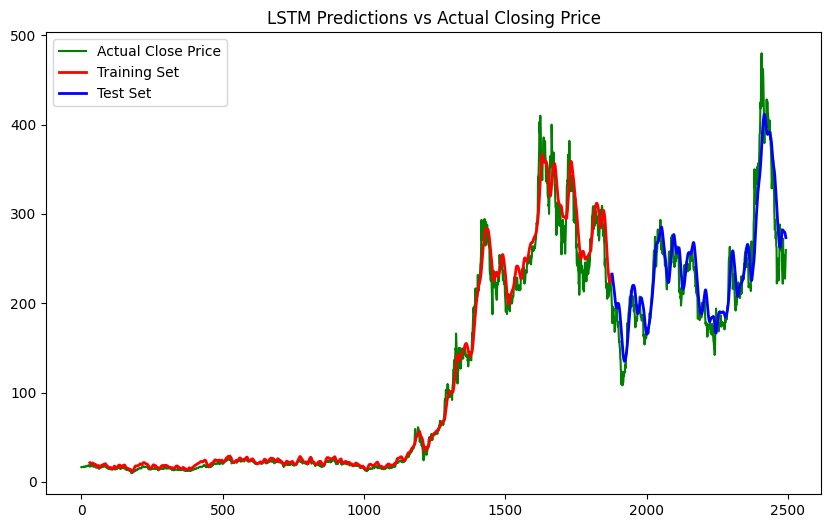

In [113]:
# training & test set plotting
plt.figure(figsize=(10,6))
plt.plot(target.values.ravel(), label='Actual Close Price', color='green')
plt.plot(train_set_plot, label='Training Set', linewidth=2, color='red')
plt.plot(test_set_plot, label='Test Set', linewidth=2, color='blue')
plt.title('LSTM Predictions vs Actual Closing Price')
plt.legend()
plt.show()

In the training set, the predicted values track the actual prices quite well, showing that the model is able to learn from the training data. For the test set, the model still does a good job following the trend but diverges more from the actual values, especially during volatile periods. This suggests that while the model does an excellent job capturing the overall trend of the stock, it may struggle to handle short-term volatility and fluctuations in stock prices on unseen data.

### Actual vs Predicted Prices (Scatter Plot)

The scatter plot below shows the relationship between the actual stock prices (x-axis) and the predicted stock prices (y-axis). The red line shows the ideal relationship, where predictions exactly match actual values.

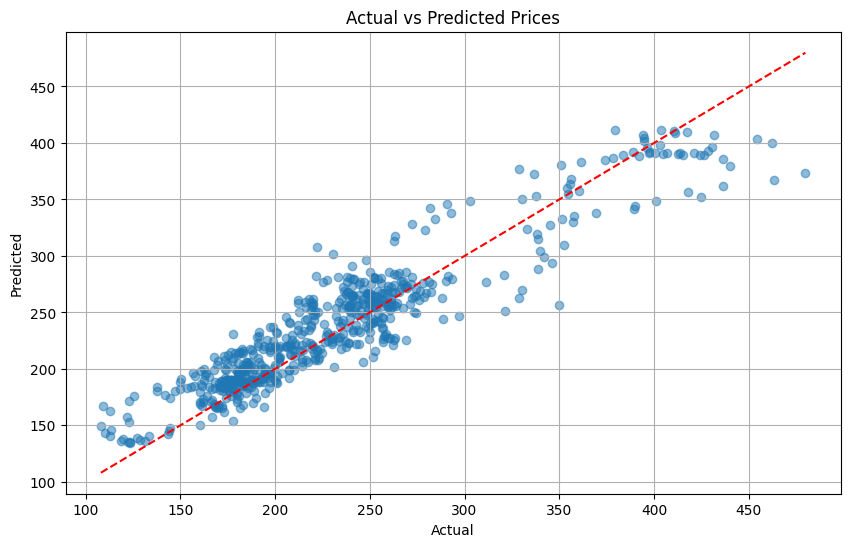

In [114]:
# actual vs predicted scatter
plt.figure(figsize=(10,6))
plt.scatter(y_test, testPredict, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # identity line
plt.title('Actual vs Predicted Prices')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.grid(True)
plt.show()

The scatter plot shows a high correlation between the predicted and actual prices, with a majority of data points close to the perfect dashed red line. This demonstrates the general accuracy of the model's projections. Yet, there are also points spread out from the line, indicating points where the projections of the model fell short of the actual values. The points of departure from the line are most apparent in the high-end price points, indicating the model performs best at forecasting mid-level stock prices but cannot accurately estimate the extreme points at high or low prices.

### Additional Metrics

In [115]:
# evaluation
mae = mean_absolute_error(y_test, testPredict)
r2 = r2_score(y_test, testPredict)
mape = np.mean(np.abs((y_test-testPredict)/y_test))*100

print(f"Mean Abs Error: {mae:.2f}")
print(f"R^2 Score: {r2:.2f}")
print(f"Mean Abs Percentage Error: {mape:.2f}%")

Mean Abs Error: 19.00
R^2 Score: 0.86
Mean Abs Percentage Error: 8.61%


The Mean Absolute Error (MAE) of 19.00 is not perfect, but is fairly reasonable considering the complexity and volatility of stock price prediction. Since Tesla’s stock can fluctuate quite a lot, to have an error of $19 on average indicates that the model is getting the general direction right. The R² value of 0.86 is also impressive, and it indicates that the model captures 86% of the variance in the stock prices. This is a high achievement considering financial data, where market volatility and external factors usually contribute to the difficulty in prediction. Furthermore, the Mean Absolute Percentage Error (MAPE) of 8.61% in the context of the problem at hand is excellent, as the error of 8.61% represents a very good performance considering the market noise and the daily price movements. The results demonstrate the ability of the model to learn from the complex financial patterns and give accurate predictions in spite of the volatile stock market.

## Conclusion

This project demonstrated the potential of machine learning, specifically the combination of LSTM networks and CNNs, to predict Tesla's stock price. The model performed well in the bigger picture on general trends, though struggled with extreme price movements, a common occurrence in stock market prediction. The results of this project show the combination of technical indicators with deep learning provides a strong foundation for forecasting stock prices, but further improvements could include adding external factors like market sentiment (news) or more advanced models.